## Prepare the workspace

In [1]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

2.4.1+cu121
True


In [2]:
#imports
# creating function for maintaining reproducibility
import torch
import torch.nn as nn

import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
try:
    from torchinfo import summary
    from tqdm.autonotebook import tqdm
    from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
except:
    # installing torchinfo and then importing
    print("[INFO] Installing torchinfo for network architecture explanation.")
    !pip install torchinfo
    from torchinfo import summary

    # for readability
    print()

    # installing tqdm and then importing
    print("[INFO] Installing tqdm for progress bar.")
    !pip install tqdm
    from tqdm.autonotebook import tqdm

    # for readability
    print()

    # installing torchmetrics and importing MulticlassAccuracy and MulticlassF1Score
    print("[INFO] Installing torchmetrics for computing metrics for training/eval runs.")
    !pip install torchmetrics
    from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

def manual_seed(random_seed: int = 42) -> None:
    '''
    For maintaining reproducibility of a notebook cell.
    '''
    # for non-cuda
    torch.manual_seed(random_seed)
    # in case cuda exists
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)

# creating device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# clearing cache if using GPU
if str(device) == "cuda":
    torch.cuda.empty_cache()


<ipython-input-2-26da887662c9>:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
# Imports here
import os
import requests
from pathlib import Path
import tarfile


# defining dataset directory
data_dir = './flowers'
# using pathlib.Path for handling PosixPath
FLOWERS_DIR = Path(data_dir)

# downloading and setting up data if not already present
if not FLOWERS_DIR.is_dir():
    # creating directory
    FLOWERS_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Directory created: ./{FLOWERS_DIR}")
    print() # for readability
    # tarball path
    TARBALL = FLOWERS_DIR / "flower_data.tar.gz"

    # downloading and writing the tarball to './flowers' directory
    print(f"[INFO] Downloading the file 'flower_data.tar.gz' to ./{FLOWERS_DIR}")
    request = requests.get('https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz')
    with open(TARBALL, "wb") as file_ref:
        file_ref.write(request.content)
        print(f"[INFO] 'flower_data.tar.gz' saved to ./{FLOWERS_DIR}")

    print() # for readability

    # extracting the downloaded tarball
    print(f"[INFO] Extracting the downloaded tarball to ./{FLOWERS_DIR}")
    with tarfile.open(TARBALL, "r") as tar_ref:
        tar_ref.extractall(FLOWERS_DIR)
        print(f"[INFO] 'flower_data.tar.gz' extracted successfully to ./{FLOWERS_DIR}")

    print() # for readability

    # using os.remove to delete the downloaded tarball
    print("[INFO] Deleting the tarball to save space.")
    os.remove(TARBALL)
else:
    print(f"[INFO] Dataset already setup at ./{FLOWERS_DIR}")

[INFO] Dataset already setup at ./flowers


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands.

**Method 1**
```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


**Method 2**
```bash
!cp -r /data/ .
```

## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [4]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [38]:
import json

data = {
    "21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster",
    "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy",
    "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly",
    "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist",
    "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower",
    "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation",
    "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone",
    "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow",
    "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid",
    "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia",
    "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura",
    "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium",
    "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily",
    "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william",
    "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon",
    "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula",
    "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower",
    "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple",
    "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus",
    "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily",
    "46": "wallflower", "77": "passion flower", "51": "petunia"
}

with open('cat_to_name.json', 'w') as file:
    json.dump(data, file)
    print("[INFO] cat_to_name.json created")


[INFO] cat_to_name.json created


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active.

## Note for Workspace users:
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 5
HIDDEN_LAYER_1 = 256
HIDDEN_LAYER_2 = 128


In [7]:
# TODO: Build and train your network

# an overview of how the multi-weight support API works: need torch v1.12+ and torchvision 0.14+
vit_b_weights = torchvision.models.ViT_B_16_Weights.DEFAULT     # DEFAULT will give you the best possible weights

# we can look at the transforms used for training the given weights for this network architecture
vit_b_default_transforms = vit_b_weights.transforms()

# checking transforms
print(vit_b_default_transforms)

# creating ViT architecture using the weights specified above
model = torchvision.models.vit_b_16(weights = vit_b_weights)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [8]:
# using torchinfo to inspect the network
#vit summary
summary(model,
        input_size=(1,3,224,224),
        col_names=("input_size",
                   "output_size",
                   "num_params",
                   "kernel_size",
                   "mult_adds",
                   "trainable"),
        col_width=17,
        row_settings=("var_names",))

Layer (type (var_name))                                      Input Shape       Output Shape      Param #           Kernel Shape      Mult-Adds         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]  [1, 1000]         768               --                --                True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]  [1, 768, 14, 14]  590,592           [16, 16]          115,756,032       True
├─Encoder (encoder)                                          [1, 197, 768]     [1, 197, 768]     151,296           --                --                True
│    └─Dropout (dropout)                                     [1, 197, 768]     [1, 197, 768]     --                --                --                --
│    └─Sequential (layers)                                   [1, 197, 768]     [1, 197, 768]     --                --                --                True
│    │    └─EncoderBlock (encoder_layer_0)                   

In [9]:
# TODO: Define your transforms for the training, validation, and testing sets
# we can either use these transforms or compose transforms manually (doing train_transforms manually because we need data augmentation)

# 1. training transform: if TrivialAugmentWide is not available for your torchvision version use other data augmentation techniques (https://pytorch.org/vision/stable/transforms.html#v1-api-reference)
train_transforms = transforms.Compose([transforms.Resize(size=(224,224),
                                                         interpolation=transforms.InterpolationMode.BILINEAR),
                                       transforms.RandomRotation(degrees=(-15,-15),
                                                                 interpolation = transforms.InterpolationMode.BILINEAR),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.CenterCrop(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
# 1. training dataset
train_dataset = torchvision.datasets.ImageFolder(root=train_dir,
                                        transform=train_transforms)

# 2. validation dataset
val_dataset = torchvision.datasets.ImageFolder(root = valid_dir,
                                      transform=vit_b_default_transforms)

# 2. validation dataset
test_dataset = torchvision.datasets.ImageFolder(root = test_dir,
                                      transform=vit_b_default_transforms)

# extracting number of classes and class_to_idx mapping
CLASSES = train_dataset.classes

NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = train_dataset.class_to_idx

# TODO: Using the image datasets and the trainforms, define the dataloaders
# creating dataloaders

# 1. training set dataloader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=os.cpu_count() if str(device) == "cuda" else 0,      # if you have GPU it makes sense to spin up multiple worker processes to fetch data batches, num_workers=<cpu cores> is a good rule of thumb (https://stackoverflow.com/a/54002191)
                                           pin_memory=True if str(device) == "cuda" else False)             # if you have GPU it almost always makes sense to have 'pin_memory = True', as this makes the data transfer to GPU more efficient (https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723/2)

# 2. validation set dataloader
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=os.cpu_count() if str(device) == "cuda" else 0,
                                         pin_memory=True if str(device) == "cuda" else False)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=os.cpu_count() if str(device) == "cuda" else 0,
                                         pin_memory=True if str(device) == "cuda" else False)


In [10]:
# swapping out the ViTnet classifier head
# using the function 'manual_seed()' created above to lock reproducibility of this cell
manual_seed()
# freezing out the complete network first
for param in model.parameters():
    param.requires_grad = False

model.heads = nn.Sequential(
    nn.Linear(768, HIDDEN_LAYER_1),  # 1280 is the output size of EfficientNet V2 S
    nn.ReLU(),  # Use SiLU instead of ReLU
    nn.Linear(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
    nn.ReLU(),  # Use SiLU instead of ReLU
    nn.Linear(HIDDEN_LAYER_2, len(train_dataset.classes))  # Use the correct number of classes
)


In [11]:
# checking details after freezing the convolution backbone and swapping out the classifier head
summary(model,
        input_size=(1,3,224,224),
        col_names=("input_size",
                   "output_size",
                   "num_params",
                   "kernel_size",
                   "mult_adds",
                   "trainable"),
        col_width=20,
        row_settings=("var_names",))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 102]             768                  --                   --                   Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            [16, 16]             115,756,032          False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              --                   --                   False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --                   --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   --           

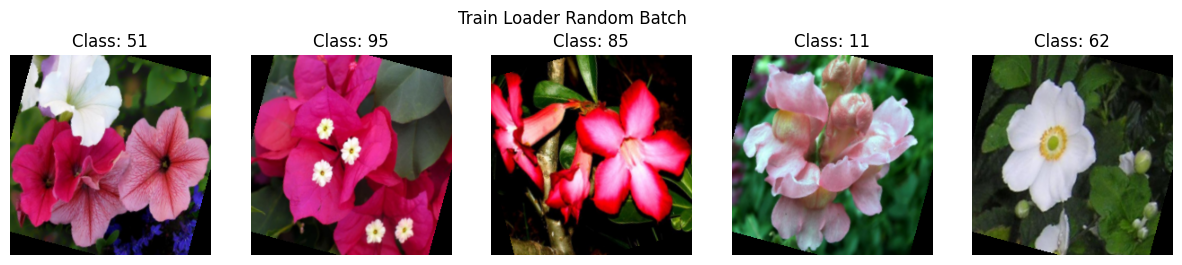

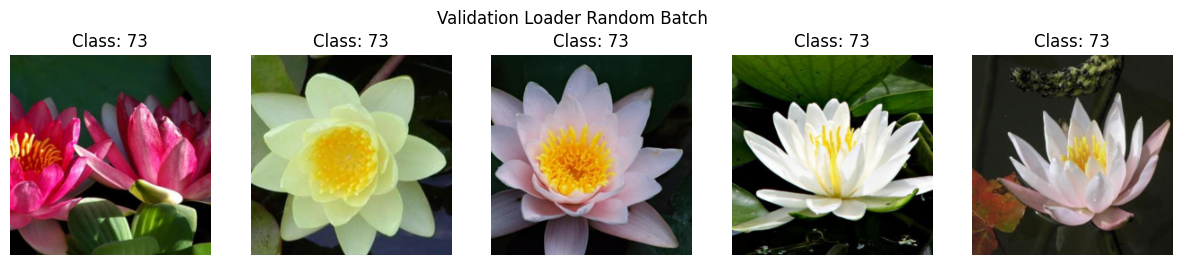

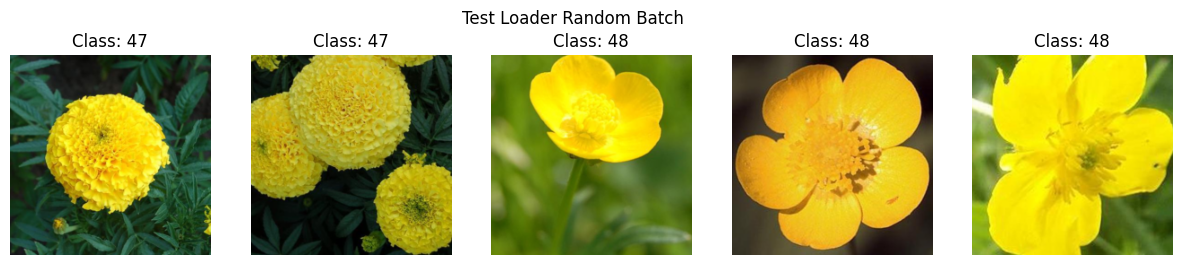

In [12]:
def denormalize_and_clip(img, mean, std):
    img = img.numpy(force=True) if isinstance(img, torch.Tensor) else img
    img = np.transpose(img, (1, 2, 0))

    # Denormalize and clip values to stay in the valid range [0, 1]
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def imshow(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # Remove ticks and axes
    plt.show()

def visualize_random_batch(data_loader, loader_type, mean, std):
    # Get a random batch index
    batch_index = np.random.randint(len(data_loader))

    # Get the random batch from the data loader
    for i, (images, labels) in enumerate(data_loader):
        if i == batch_index:
            break

    # Define the classes (assuming your dataset has a 'classes' attribute)
    classes = data_loader.dataset.classes

    # Display images from the random batch in a grid
    num_images_to_show = min(5, len(images))  # Display at most 5 images
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

    for i in range(num_images_to_show):
        image = images[i]
        label = labels[i].item()
        class_name = classes[label]

        # Show the image
        image = denormalize_and_clip(image, mean, std)  # Apply denormalization
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')  # Remove ticks and axes

    plt.suptitle(f'{loader_type} Random Batch')
    plt.show()

# Example usage with your dataloaders
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

visualize_random_batch(train_loader, 'Train Loader', mean, std)  # Visualization of a random batch from the training set
visualize_random_batch(val_loader, 'Validation Loader', mean, std)  # Visualization of a random batch from the validation set
visualize_random_batch(test_loader, 'Test Loader', mean, std)  # Visualization of a random batch from the validation set


In [13]:
# creating a single step of training
import os
import requests
import copy
import time
import functools
from zipfile import ZipFile
from pathlib import Path
from typing import Tuple, Callable, Union, Any
def training_step(model: nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  criterion: nn.Module,
                  training_accuracy: MulticlassAccuracy,
                  training_f1: MulticlassF1Score,
                  epoch_num: int,
                  device: torch.device = device) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    '''
    Function for a single step of training.

    Args:
        model: The model/network to train
        train_dataloader: The dataloader for training set
        optimizer: The optimization algorithm to use
        criterion: The error function for setting up the optimization problem
        training_accuracy: Instance of MulticlassAccuracy class from torchmetrics
        training_f1: Instance of MulticlassF1Score class from torchmetrics
        epoch_num: The current epoch number
        device: The device being used for model/network training [Default: device]

    Returns:
        Tuple of training loss, training accuracy and training f1 score
    '''

    # setting the model to train mode
    model.train()

    # placeholder for calculating loss epoch wise
    epoch_loss = 0

    # using tqdm for progress bar
    with tqdm(enumerate(train_dataloader, start=1), total=len(train_dataloader), unit=" train-batch") as tepoch:
        # iterating over the data batches
        for batch_idx, (features, labels) in tepoch:
            # setting description (prefix) for tqdm progress bar
            tepoch.set_description(f"Epoch: {epoch_num+1} | Phase - Training")

            # moving the batches to device
            features, labels = features.to(device), labels.to(device).type(torch.long)      # typecasting labels (if using CE Loss)

            # doing forward propagation
            logits = model(features)
            # calculating loss
            loss = criterion(logits, labels)
            # zeroing out accumulated gradients from the previous iteration
            optimizer.zero_grad()
            # doing backpropagation: computing partial derivatives
            loss.backward()
            # taking an optimization step using the gradients computed above
            optimizer.step()

            # calculating average loss and Accuracy/F1-Score per batch (removing this part from computation graph)
            with torch.inference_mode():        # use torch.no_grad() if torch.inference_mode() is not available in PyTorch version
                avg_loss_sample = loss/len(labels)
                batch_acc = training_accuracy.forward(logits, labels)
                batch_f1 = training_f1.forward(logits, labels)

            # accumulating in epoch loss
            epoch_loss += avg_loss_sample

            # setting postfix for progress bar
            tepoch.set_postfix(batch_f1_score=batch_f1.item(), batch_accuracy=f"{batch_acc.item()*100:.2f}%", loss_per_sample=avg_loss_sample.item())

    # averaging loss over batches
    epoch_loss /= len(train_dataloader)

    # for readability
    print()

    # printing epoch statistics
    print(f"[INFO] Epoch: {epoch_num+1} | loss: {epoch_loss.item():.3f} | training acc: {training_accuracy.compute().item()*100:.2f}% | training f1-score: {training_f1.compute().item():.2f}")

    # returning loss, acc and f1
    return epoch_loss, training_accuracy.compute(), training_f1.compute()


In [14]:
# creating a single step of testing

def testing_step(model: nn.Module,
                 test_dataloader: torch.utils.data.DataLoader,
                 criterion: nn.Module,
                 test_accuracy: MulticlassAccuracy,
                 test_f1: MulticlassF1Score,
                 epoch_num: int = -1,
                 device: torch.device = device) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    '''
    Function for a single step of testing.

    Args:
        model: The model/network to train
        test_dataloader: The dataloader for test set
        criterion: The error function for quantifying how wrong predictions are
        test_accuracy: Instance of MulticlassAccuracy class from torchmetrics
        test_f1: Instance of MulticlassF1Score class from torchmetrics
        epoch_num: The current epoch number [Default: -1]
        device: The device being used for model/network testing [Default: device]

    Returns:
        Tuple of test loss, test accuracy and test f1 score
    '''

    # setting the model to eval mode
    model.eval()

    # placeholder for calculating loss epoch wise
    epoch_loss = 0

    # using tqdm for progress bar
    with tqdm(enumerate(test_dataloader, start=1), total=len(test_dataloader), unit=" test-batch") as tepoch:
        # iterating over the data batches
        for batch_idx, (features, labels) in tepoch:
            # setting description (prefix) for tqdm progress bar
            tepoch.set_description(f"Epoch: {epoch_num+1} | Phase - Validation/Test")

            # moving the batches to device
            features, labels = features.to(device), labels.to(device).type(torch.long)      # typecasting labels (if using CE Loss)

            # doing forward poss + loss computation, calculating average loss and Accuracy/F1-Score per batch (removing this part from computation graph)
            with torch.inference_mode():        # use torch.no_grad() if torch.inference_mode() is not available in PyTorch version
                # doing forward propagation
                logits = model(features)
                # calculating loss
                loss = criterion(logits, labels)
                # calculating per sample loss in a batch
                avg_loss_sample = loss/len(labels)
                # calculating accuracy for the batch
                batch_acc = test_accuracy.forward(logits, labels)
                # calculating f1-score for the batch
                batch_f1 = test_f1.forward(logits, labels)

            # accumulating in epoch loss
            epoch_loss += avg_loss_sample

            # setting postfix for progress bar
            tepoch.set_postfix(batch_f1_score=batch_f1.item(), batch_accuracy=f"{batch_acc.item()*100:.2f}%", loss_per_sample=avg_loss_sample.item())

    # averaging loss over batches
    epoch_loss /= len(test_dataloader)

    # for readability
    print()

    # printing epoch statistics
    print(f"[INFO] Epoch: {epoch_num+1} | loss: {epoch_loss.item():.3f} | val/test acc: {test_accuracy.compute().item()*100:.2f}% | val/test f1-score: {test_f1.compute().item():.2f}")

    # for readability
    print()

    # returning loss, acc and f1
    return epoch_loss, test_accuracy.compute(), test_f1.compute()


In [15]:
# decorating function for training function below


def timing_function(func: Callable[..., Any]) -> Callable[..., Any]:
    '''
    Decorating function for determining the time taken for execution of a function.

    Args:
        func: Function whose execution time has to be determined

    Returns:
        wrapper function around the function whose execution time we have to determine
    '''

    # using wraps to preserve function signature
    @functools.wraps(func)
    def wrapper(*args, **kwargs) -> Any:
        '''
        The wrapper function wrapping the function that was input to timing_function.

        Args:
            *args: Variable length positional argument(s)
            *kwargs: Variable length keyword argument(s)

        Returns:
            Any output received from the 'func' function
        '''

        # computing time taken for execution of function (training pipeline etc.)
        start_time = time.perf_counter()
        func_out = func(*args, **kwargs)
        end_time = time.perf_counter()

        # for readability
        print()
        print()

        # printing time statistics
        print(f"[INFO] Time taken -> {(end_time-start_time)//60}m and {(end_time-start_time)%60:.2f}s")

        # return statement for wrapper
        return func_out
    # returning wrapper

    return wrapper

In [16]:
# training pipeline: combining the two functions training_step and testing_step
@timing_function
def training(model: nn.Module,
             train_dataloader: torch.utils.data.DataLoader,
             test_dataloader: torch.utils.data.DataLoader,
             optimizer: torch.optim.Optimizer,
             criterion: nn.Module,
             training_accuracy: MulticlassAccuracy,
             training_f1: MulticlassF1Score,
             test_accuracy: MulticlassAccuracy,
             test_f1: MulticlassF1Score,

             epochs: int = 5,
             device: torch.device = device) -> Tuple[dict, dict]:
             '''
             Function defining the training pipeline.

             Args:
                 model: The model/network to train
                 train_dataloader: The dataloader for training set
                 test_dataloader: The dataloader for test set
                 optimizer: The optimization algorithm to use
                 criterion: The error function for setting up the optimization problem
                 training_accuracy: Instance of MulticlassAccuracy class from torchmetrics (for training)
                 training_f1: Instance of MulticlassF1Score class from torchmetrics (for training)
                 test_accuracy: Instance of MulticlassAccuracy class from torchmetrics (for test)
                 test_f1: Instance of MulticlassF1Score class from torchmetrics (for test)
                 epochs: The number of epochs to train the model for [Default: 5]
                 device: The device being used for model/network training + eval [Default: device]

             Returns:
                 None
             '''

             # moving model to device
             model.to(device)

             # moving torchmetrics metric objects to device
             training_accuracy.to(device)
             training_f1.to(device)
             test_accuracy.to(device)
             test_f1.to(device)

             # lists for tracking loss and metrics
             train_loss = []
             train_acc = []
             train_f1 = []
             val_loss = []
             val_acc = []
             val_f1 = []

             # will be used for keeping track of best performing model
             best_loss = float("inf")

             # training model for given number of epochs
             for epoch_iter in range(epochs):
                # single step of training
                train_epoch_loss, train_epoch_acc, train_epoch_f1 = training_step(model,
                                                                                  train_dataloader,
                                                                                  optimizer,
                                                                                  criterion,
                                                                                  training_accuracy,
                                                                                  training_f1,
                                                                                  epoch_iter,
                                                                                  device)
                # appending to respective lists (train)
                train_loss.append(train_epoch_loss)
                train_acc.append(train_epoch_acc)
                train_f1.append(train_epoch_f1)

                # for readability
                print()

                # single step of validation
                val_epoch_loss, val_epoch_acc, val_epoch_f1 = testing_step(model,
                                                                           test_dataloader,
                                                                           criterion,
                                                                           test_accuracy,
                                                                           test_f1,
                                                                           epoch_iter,
                                                                           device)
                # appending to respective lists (test)
                val_loss.append(val_epoch_loss)
                val_acc.append(val_epoch_acc)
                val_f1.append(val_epoch_f1)

                # for readability
                print()

                # checking if loss has improved
                if best_loss > val_epoch_loss:
                    best_model = copy.deepcopy(model.state_dict())       # taking a deepcopy of model.state_dict()
                    best_loss = val_epoch_loss
                    best_epoch = epoch_iter

             # using list comprehension for loss, acc and f1 lists
             train_loss = [tensor.item() for tensor in train_loss]
             train_acc = [tensor.item() for tensor in train_acc]
             train_f1 = [tensor.item() for tensor in train_f1]
             val_loss = [tensor.item() for tensor in val_loss]
             val_acc = [tensor.item() for tensor in val_acc]
             val_f1 = [tensor.item() for tensor in val_f1]

             # creating training statistics dictionary
             training_statistics = {"training_loss": train_loss,
                                    "training_accuracy": train_acc,
                                    "training_f1": train_f1,
                                    "validation_loss": val_loss,
                                    "validation_accuracy": val_acc,
                                    "validation_f1": val_f1,
                                    "best_epoch": best_epoch+1,
                                    "loss_on_best_epoch": best_loss.item(),
                                    "device_used": device}

             # for readability
             print()
             print()

             # printing training statistics
             print(f"Best epoch: {training_statistics['best_epoch']} | Training acc on best epoch: {training_statistics['training_accuracy'][training_statistics['best_epoch']-1]*100:.2f}% | Validation acc on best epoch: {training_statistics['validation_accuracy'][training_statistics['best_epoch']-1]*100:.2f}%")

             # returning best performing model and statistics dictionary
             return best_model, training_statistics


In [17]:
# for saving and loading model

# saving model
def save_model(model: nn.Module,
               model_name: str) -> str:
    '''
    Function for saving state_dict of model.

    Args:
        model: model (nn.Module) whose state_dict you have to save
        model_name: The name to use for saving the state_dict

    Returns:
        The path to saved state_dict (str)
    '''

    # model save location
    SAVE_PATH = f"./{model_name}.pt"

    # saving model and printing message
    torch.save(model.state_dict(), SAVE_PATH)
    print(f"[INFO] {model_name} saved to {SAVE_PATH}")

    # returning path of saved model
    return SAVE_PATH

# saving general checkpoint
def save_checkpoint(optimizer: torch.optim.Optimizer,
                    criterion: nn.Module,
                    epoch: int,
                    device_trained_on: torch.device,
                    hidden_layers: tuple,
                    output_layer: int,
                    classes: list,
                    class_to_idx: dict,
                    checkpoint_name: str = "checkpoint") -> str:
    '''
    Function for saving the general checkpoint including anything important other than state_dict() of model.

    Args:
        optimizer: optimizer whose state_dict has to be saved
        criterion: loss/criterion used for training the network
        epoch: The epoch number of best performing model
        device_trained_on: The device on which the model was trained on
        hidden_layers: The specifications of the two hidden layers
        classes: The list of classes for the given classification problem
        class_to_idx: The class to index mapping/dictionary
        dheckpoint_name: The name by which to save the general checkpoint

    Returns:
        The path to saved general checkpoint (str)
    '''

    # checkpoint save location
    SAVE_PATH = f"./{checkpoint_name}.pth"

    # saving the checkpoint
    torch.save({"optimizer": optimizer.state_dict(),
                "criterion": criterion,
                "epoch": epoch,
                "device_trained_on": device_trained_on,
                "hidden_layers": hidden_layers,
                "output_layer": output_layer,
                "classes": classes,
                "class_to_idx": class_to_idx}, SAVE_PATH)

    # printing save confirmation
    print(f"[INFO] The general checkpoint has been saved to: {SAVE_PATH}")

    # returning the saved checkpoint path
    return SAVE_PATH

# loading model
def load_model(model_save_path: str,
               hidden_layers: tuple,
               output_layer: int,
               device_trained_on: torch.device,
               device: torch.device) -> nn.Module:
    '''
    Function for loading state_dict() of the saved model and inserting that into a newly defined architecture (must be same as original model arch).

    Args:
        model_save_path: Save path to the state_dict() of model
        hidden_layers: The specifications of the two hidden layers
        output_layer: The specification of the output layer
        device_trained_on: The device on which the model was trained on originally
        device: The device on which the newly defined model should be moved to

    Returns:
        The model with loaded state_dict()
    '''

    # building
    model = torchvision.models.vit_b_16(weights = None)

    # swapping classifier head using hidden layers
    model.heads = nn.Sequential(
    nn.Linear(768, HIDDEN_LAYER_1),
    nn.ReLU(),
    nn.Linear(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
    nn.ReLU(),
    nn.Linear(HIDDEN_LAYER_2, len(train_dataset.classes))  # Use the correct number of classes
)

    # loading model state_dict
    if str(device_trained_on) in ("cuda", "cuda:0"):
        # saved on GPU, loading on CPU case
        if str(device) == "cpu":
            model.load_state_dict(torch.load(model_save_path, map_location=device))
        # saved on GPU, loading on GPU case
        elif str(device) in ("cuda", "cuda:0"):
            model.load_state_dict(torch.load(model_save_path))
    else:
        # saved on CPU, loading on CPU case
        if str(device) == "cpu":
            model.load_state_dict(torch.load(model_save_path))
        # saved on CPU, loading on GPU case
        elif str(device) in ("cuda", "cuda:0"):
            model.load_state_dict(torch.load(model_save_path, map_location="cuda:0"))

    # moving model to device and switching to eval mode
    model.to(device);
    model.eval();

    # returning model
    return model

# loading model
def load_checkpoint(checkpoint_save_path: str) -> dict:
    '''
    Function for loading checkpoint dictionary from given path of the saved checkpoint.

    Args:
        checkpoint_save_path: Path to the general checkpoint .pth file

    Returns:
        The checkpoint dictionary (dict)
    '''

    # returning checkpoint dictionary
    CHECKPOINT_DICT = torch.load(checkpoint_save_path)
    return CHECKPOINT_DICT


In [18]:
import torch.optim as optim


# creating criterion, optimizer and metrics
# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.heads.parameters(), lr=LEARNING_RATE)

# creating metrics to be used in training pipeline (for training and validation phase)
training_acc = MulticlassAccuracy(num_classes = NUM_CLASSES)
training_f1 = MulticlassF1Score(num_classes = NUM_CLASSES)
val_acc = MulticlassAccuracy(num_classes = NUM_CLASSES)
val_f1 = MulticlassF1Score(num_classes = NUM_CLASSES)

In [19]:

#learning rate is 1e
# using manual_seed for reproducbility
manual_seed()
# starting training
vit_state_dict, training_stats = training(model,
                                             train_dataloader = train_loader,
                                             test_dataloader = val_loader,
                                             optimizer = optimizer,
                                             criterion = criterion,
                                             training_accuracy = training_acc,
                                             training_f1 = training_f1,
                                             test_accuracy = val_acc,
                                             test_f1 = val_f1,
                                             epochs=EPOCHS)


  0%|          | 0/205 [00:00<?, ? train-batch/s]


[INFO] Epoch: 1 | loss: 0.071 | training acc: 39.90% | training f1-score: 0.42



  0%|          | 0/26 [00:00<?, ? test-batch/s]


[INFO] Epoch: 1 | loss: 0.034 | val/test acc: 67.71% | val/test f1-score: 0.66




  0%|          | 0/205 [00:00<?, ? train-batch/s]


[INFO] Epoch: 2 | loss: 0.019 | training acc: 60.19% | training f1-score: 0.63



  0%|          | 0/26 [00:00<?, ? test-batch/s]


[INFO] Epoch: 2 | loss: 0.019 | val/test acc: 74.50% | val/test f1-score: 0.73




  0%|          | 0/205 [00:00<?, ? train-batch/s]


[INFO] Epoch: 3 | loss: 0.010 | training acc: 70.25% | training f1-score: 0.73



  0%|          | 0/26 [00:00<?, ? test-batch/s]


[INFO] Epoch: 3 | loss: 0.013 | val/test acc: 77.77% | val/test f1-score: 0.77




  0%|          | 0/205 [00:00<?, ? train-batch/s]


[INFO] Epoch: 4 | loss: 0.006 | training acc: 76.29% | training f1-score: 0.79



  0%|          | 0/26 [00:00<?, ? test-batch/s]


[INFO] Epoch: 4 | loss: 0.012 | val/test acc: 80.70% | val/test f1-score: 0.80




  0%|          | 0/205 [00:00<?, ? train-batch/s]


[INFO] Epoch: 5 | loss: 0.004 | training acc: 80.39% | training f1-score: 0.82



  0%|          | 0/26 [00:00<?, ? test-batch/s]


[INFO] Epoch: 5 | loss: 0.011 | val/test acc: 82.44% | val/test f1-score: 0.81




Best epoch: 5 | Training acc on best epoch: 80.39% | Validation acc on best epoch: 82.44%


[INFO] Time taken -> 8.0m and 30.47s


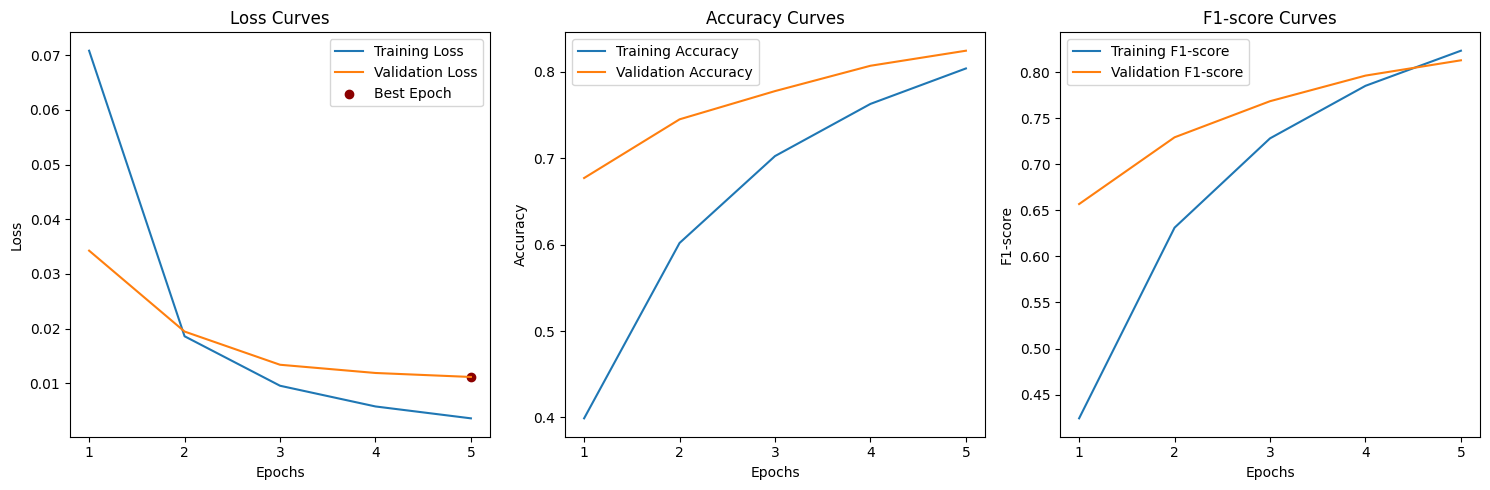

In [20]:
# function to plot curves

def plot_curves(stats):
    # Extract data from the dictionary
    training_loss = stats['training_loss']
    training_accuracy = stats['training_accuracy']
    training_f1 = stats['training_f1']

    validation_loss = stats['validation_loss']
    validation_accuracy = stats['validation_accuracy']
    validation_f1 = stats['validation_f1']

    best_epoch = stats['best_epoch']
    loss_on_best_epoch = stats['loss_on_best_epoch']

    epochs = range(1, len(training_loss) + 1)

    # Plotting loss curve
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.scatter(best_epoch, loss_on_best_epoch, color='darkred', marker='o', label='Best Epoch')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)  # Ensure x-axis ticks are integers
    plt.legend()

    # Plotting accuracy curve
    plt.subplot(1, 3, 2)
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)  # Ensure x-axis ticks are integers
    plt.legend()

    # Plotting F1-score curve
    plt.subplot(1, 3, 3)
    plt.plot(epochs, training_f1, label='Training F1-score')
    plt.plot(epochs, validation_f1, label='Validation F1-score')
    plt.title('F1-score Curves')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.xticks(epochs)  # Ensure x-axis ticks are integers
    plt.legend()

    plt.tight_layout()
    plt.show()

# displaying curves
plot_curves(training_stats)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [22]:
# DONE: Do validation on the test set
def test_model(model,test_loader,criterion,device):
    model.eval()
    test_loss=0.0
    correct,total=0,0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return test_loss / len(test_loader), 100 * correct / total

test_loss, test_accuracy=test_model(model,test_loader,criterion,device)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.404, Test Accuracy: 89.26%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [23]:
# TODO: Save the checkpoint
# saving model and checkpoint
MODEL_SAVE_PATH = save_model(model, "vit_b_16_1e")
CHKPT_SAVE_PATH = save_checkpoint(optimizer,
                                  criterion,
                                  epoch = training_stats["best_epoch"]-1,
                                  device_trained_on = device,
                                  hidden_layers =(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
                                  output_layer = NUM_CLASSES,
                                  classes = CLASSES,
                                  class_to_idx = CLASS_TO_IDX,
                                  checkpoint_name = "checkpoint")


[INFO] vit_b_16_1e saved to ./vit_b_16_1e.pt
[INFO] The general checkpoint has been saved to: ./checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [64]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# loading model and checkpoint
CHKPT_DICT = load_checkpoint(CHKPT_SAVE_PATH)

new_model = load_model(MODEL_SAVE_PATH,
                       hidden_layers = CHKPT_DICT["hidden_layers"],
                       output_layer = CHKPT_DICT["output_layer"],
                       device_trained_on = CHKPT_DICT["device_trained_on"],

                       device = torch.device("cpu"))


<ipython-input-17-5fbd742df0e3>:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CHECKPOINT_DICT = torch.load(checkpoint_save_path)
<ipython-input-17-5fbd742df0e3>:109: Fu

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [71]:
# function to predict on a give image sample and draw a bargraph

@timing_function
def predict_and_plot_topk(model: nn.Module,
                          cat_to_name:json,
                          img_transform: transforms.Compose,
                          class_list: list,
                          image_path: str,
                          device: torch.device,
                          topk: int = 5):

    # Load and preprocess the image

    image = Image.open(image_path).convert("RGB")
    input_tensor = img_transform(image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    # Moving model to device and switching to eval mode
    model.to(device)
    model.eval()

    # Make predictions
    with torch.inference_mode():
        output = model(input_batch)

    # Convert the output to probabilities using softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Get the top-k class indices and probabilities
    topk_probs, topk_indices = torch.topk(probabilities, topk)
    topk_probs_np = topk_probs.numpy(force=True)
    topk_indices_np = topk_indices.numpy(force=True)

    topk_classes = [CLASSES[index] for index in topk_indices_np]

    labels = [cat_to_name[str(cls)] for cls in topk_classes]

    probability = topk_probs_np
    # Convert tensor to numpy array for plotting
    probs_np = probabilities.numpy(force=True)

    # Create a horizontal bar graph
    plt.figure(figsize=(10, 6))

    # Plot the image
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')

    # Plot the top-k classes
    plt.subplot(2, 1, 2)
    plt.barh(labels, topk_probs_np, color='blue')
    #plt.barh([class_list[i] for i in topk_indices_np], topk_probs_np, color='blue')
    plt.xlabel('Predicted Probability')
    plt.title(f'Top-{topk} Predicted Classes')

    plt.tight_layout()
    plt.show()


In [68]:
with open('cat_to_name.json', 'r') as json_file:
    cat_to_name = json.load(json_file)

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

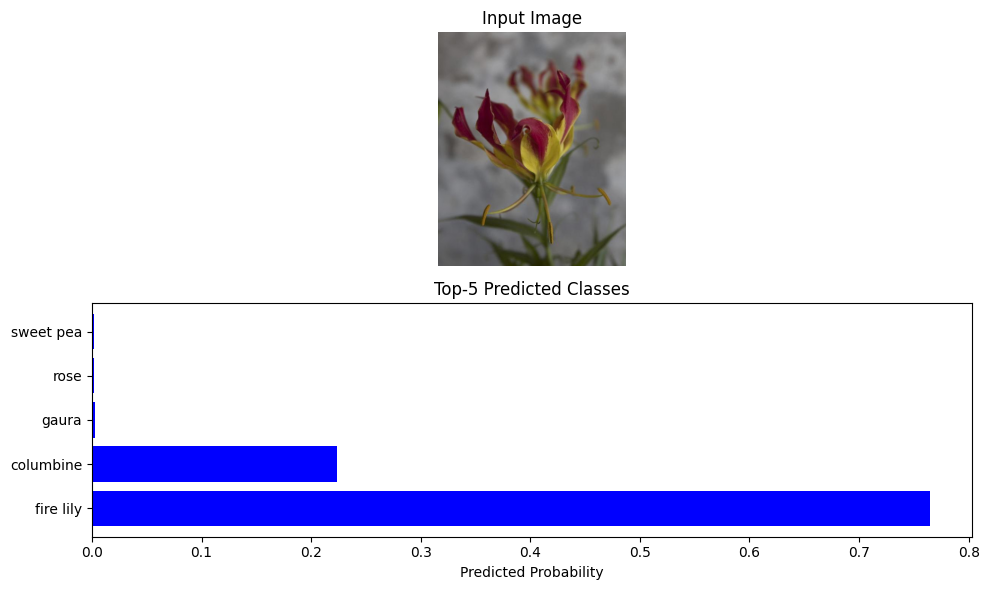



[INFO] Time taken -> 0.0m and 0.36s


In [72]:
# TODO: Display an image along with the top 5 classes
# Assuming you have a PyTorch model 'new_model', a list of class names extracted using dataset_name.classes, and an image file path
predict_and_plot_topk(new_model,
                      cat_to_name,
                      vit_b_default_transforms,
                      CLASSES,
                      "/content/flowers/test/21/image_06805.jpg",
                      device,
                      topk=5)


## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again.
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [ ]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace
!rm checkpoint.pth

In [ ]:
# Save the notebook as HTML
!jupyter nbconvert --to html '/content/ImageClassifierProject.ipynb'


In [ ]:
from google.colab import files

# Download the HTML file
files.download('/content/ImageClassifierProject.html')
